# Neural Network Autoencoder for anomaly detection in pcap
Unsupervised learning using autoencoder. The following approach is used:

```
pcap in --(1)--> tshark ek json --(2)--> neural network autoencoder --(3)--> top N errornous PDUs --(4)--> pcap out
```

* (1) The input json is generated by the following command from pcap: tshark -T ek -x -r trace.pcap > trace.json
* (2) Only selected raw json fields are used for learning. This is defined in COLUMNS variable. All input bytes are serialized into floats as learning features and used as input to the neural network.
* (3) Top N PDUs with highest mean square error are added into output pcap. This is controled by N variable
* (4) test_ad.pcap is created

Author: Martin Kacer

Date: Dec 29, 2017

In [568]:
#!/usr/bin/env python

#
# Anomaly detection using tensorflow and tshark
# Unsupervised learning using autoencoder
#
# Copyright 2017, H21 lab, Martin Kacer
# All the content and resources have been provided in the hope that it will be useful.
# Author do not take responsibility for any misapplication of it.
#
# Based on tensorflow classifier example wide_n_deep_tutorial.py
# Copyright 2017, The TensorFlow Authors.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
#

import sys
import json
import argparse
import tempfile
import pandas as pd
import operator
import subprocess
import os
import hashlib
from datetime import datetime
import numpy as np
import binascii
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

COLUMNS = []
LABEL_COLUMN = "label"
CATEGORICAL_COLUMNS = []
CONTINUOUS_COLUMNS = []

FLAGS = None


# Parameters
learning_rate = 0.001
training_epochs = 1000
batch_size = 200
display_step = 1

# Network Parameters
n_hidden_1 = 15 # 1st layer num features
#n_hidden_2 = 15 # 2nd layer num features
n_input = None
data_dir = '.'


# Building the encoder
def encoder(x):
    # Encoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.tanh(tf.add(tf.matmul(x, weights['encoder_h1']),
                                   biases['encoder_b1']))
    # Decoder Hidden layer with sigmoid activation #2
    #layer_2 = tf.nn.tanh(tf.add(tf.matmul(layer_1, weights['encoder_h2']),
    #                               biases['encoder_b2']))
    return layer_1


# Building the decoder
def decoder(x):
    # Encoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.tanh(tf.add(tf.matmul(x, weights['decoder_h1']),
                                   biases['decoder_b1']))
    # Decoder Hidden layer with sigmoid activation #2
    #layer_2 = tf.nn.tanh(tf.add(tf.matmul(layer_1, weights['decoder_h2']),
    #                               biases['decoder_b2']))
    return layer_1


def df_to_pcap(j, df_predict, file):
    linux_cooked_header = df_predict.at[j, 'linux_cooked_header'];
    frame_raw = df_predict.at[j, 'frame_raw']
    # for Linux cooked header replace dest MAC and remove two bytes to reconstruct normal frame using text2pcap
    if (linux_cooked_header):
        frame_raw = "000000000000" + frame_raw[6*2:] # replce dest MAC
        frame_raw = frame_raw[:12*2] + "" + frame_raw[14*2:] # remove two bytes before Protocol
    hex_to_txt(frame_raw, file)

    
def to_pcap_file(filename, output_pcap_file):
    FNULL = open(os.devnull, 'w')
    subprocess.call(["text2pcap", filename, output_pcap_file], stdout=FNULL, stderr=subprocess.STDOUT)

    
def hex_to_txt(hexstring, output_file):
    h = hexstring.lower()
    
    file = open(output_file, 'a')
    
    for i in range(0, len(h), 2):
        if(i%32 == 0):
            file.write(format(i/2, '06x') + ' ')
        
        file.write(h[i:i+2] + ' ')
        
        if(i%32 == 30):
            file.write('\n')

    file.write('\n')
    file.close()

    
def json_collector(dict, name):
    r = []
    if hasattr(dict, 'items'):
        for k, v in dict.items():
            if (k in name):
                r.append(v)
            else:
                val = json_collector(v, name)
                if (len(val) > 0):
                    r = r + val

    return r
   
    
def readJsonEKLine(df, line, label):
    # trim end of lines
    line = line.rstrip('\n')
    # skip empty lines
    if (line.rstrip() == ""):
        return

    j = json.loads(line)
                
    # frames
    if ('layers' in j):
        layers = j['layers']
        
        linux_cooked_header = False
        if ('sll_raw' in layers):
            linux_cooked_header = True
        if ('frame_raw' in layers):
            
            i = len(df)
            
            df.loc[i, 'frame_raw'] = layers['frame_raw']
            df.loc[i, 'linux_cooked_header'] = linux_cooked_header
            
            for c in COLUMNS:
                v = json_collector(j, [c])
                if (len(v) > 0):
                    v = v[0]
                else:
                    v = ''
                df.loc[i, c] = v
                
            df.loc[i, 'label'] = label
            

def readJsonEK(df, filename, label, limit = 0):
    i = 0
    while i <= limit:
        with open(filename) as f:
            for line in f:
                if (limit != 0 and i > limit):
                    return i
                readJsonEKLine(df, line, label)
                i = i + 1
    return i

# Selecting learning features
Select the raw fields from json which will be used to learn neural network

In [569]:
global COLUMNS
global CATEGORICAL_COLUMNS

# only raw json fielads are accepted
COLUMNS = ["ip_raw"]#["ip_ip_src_raw", "ip_ip_dst_raw"]
CATEGORICAL_COLUMNS = COLUMNS

print COLUMNS
print CATEGORICAL_COLUMNS
print CONTINUOUS_COLUMNS

['ip_raw']
['ip_raw']
[]


# Load and parse input JSON
Read input json which was generated from pcap by using tshark by the following command:
```
tshark -T ek -x -r trace.pcap > trace.json
```

trace.json

In [570]:
df = pd.DataFrame()

ln = readJsonEK(df, "res/trace.json", 0)
#readJsonEK(df, FLAGS.anomaly_tshark_ek_x_json, 1, ln)

df = df.sample(frac=1).reset_index(drop=True)

print(df)

#####################################
# train neural network and evaluate #
#####################################
model_dir = tempfile.mkdtemp()
print("model directory = %s" % model_dir)

                                             frame_raw linux_cooked_header  \
0    003048624e4a0008e23b56010800450004283e74400071...               False   
1    0008e23b5601003048624e4a080045000028b507400040...               False   
2    003048624e4a0008e23b56010800450005dc3ff4400071...               False   
3    0008e23b5601003048624e4a08004500003c314c400040...               False   
4    003048624e4a0008e23b56010800450004284148400071...               False   
5    003048624e4a0008e23b56010800450005dc3e8e400071...               False   
6    0008e23b5601003048624e4a080045000028b4cb400040...               False   
7    003048624e4a0008e23b560108004500042840dc400071...               False   
8    0008e23b5601003048624e4a080045000028b4d9400040...               False   
9    003048624e4a0008e23b5601080045000428411e400071...               False   
10   0008e23b5601003048624e4a080045000081059e400040...               False   
11   0008e23b5601003048624e4a080045000028b4e5400040...          

# Prepare data for neural network
Calculate bellow the maximum length of columns. This is latter used to create normalized table of floats.


In [571]:
print df.columns

v_len = 0
col_max_len = []
for i in range(len(df.columns)):
    if (df.columns[i] in COLUMNS):
        m = df[df.columns[i]].map(len).max() / 2
        col_max_len.append(m)
        if (df.columns[i] != 'timestamp'):
            v_len = v_len + m
        else:
            min_t = int(df[df.columns[i]].min())
            max_t = int(df[df.columns[i]].max())
            print min_t
            print max_t
            v_len = v_len + 1
        
    else:
        col_max_len.append(None)

print col_max_len
print v_len

Index([u'frame_raw', u'linux_cooked_header', u'ip_raw', u'label'], dtype='object')
[None, None, 20, None]
20


# Create input into neural network
np array including float values will be used as input for neural network.
* Timestamp (if included in COLUMNS) is normalized into `<0.0; 1.0>` float interval
* Bytes are normalized also into `<0.0; 1.0>` float intervals. Every byte is converted into float.

In [572]:
train_x = np.array([0]*(v_len), np.float)
#print train_x

for index, row in df.iterrows():
    #train_x = np.append(train_x, [1])
    
    f_array = []
    #print row
    c = 0
    for column in df.columns:
        if column in COLUMNS:
            #print i
            #print s
            #print s
            #print column
            v = row.loc[column]
            r = 0
            #print v
            if (column == 'timestamp'):
                v = int(v)
                #print v
                r = float(v - min_t)/float(max_t - min_t)
                #print r
                f_array.append(r)
            else:
                s = binascii.unhexlify(v)
                #print s
                for i in range(col_max_len[c]):
                    r = 0.0
                    if (i < len(s)):
                        #print ord(s[i])
                        r = float(ord(s[i]))/255.0
                    f_array.append(r)

        c = c + 1
    
    #print train_x
    #print f_array
    train_x = np.vstack([train_x, f_array])

# delete the first dummy row
train_x = np.delete(train_x, 0, 0)

print train_x
#print train_x.shape

[[ 0.27058824  0.          0.01568627 ...,  0.58823529  0.04313725
   0.43529412]
 [ 0.27058824  0.          0.         ...,  0.44705882  0.80392157  0.4       ]
 [ 0.27058824  0.          0.01960784 ...,  0.58823529  0.04313725
   0.43529412]
 ..., 
 [ 0.27058824  0.          0.01960784 ...,  0.58823529  0.04313725
   0.43529412]
 [ 0.27058824  0.          0.00784314 ...,  0.58823529  0.04313725
   0.43529412]
 [ 0.27058824  0.          0.01568627 ...,  0.58823529  0.04313725
   0.43529412]]


# Visualize input data features
Histograms of inputs features which will be forwarded to neural network

(348, 20)
(348, 15)


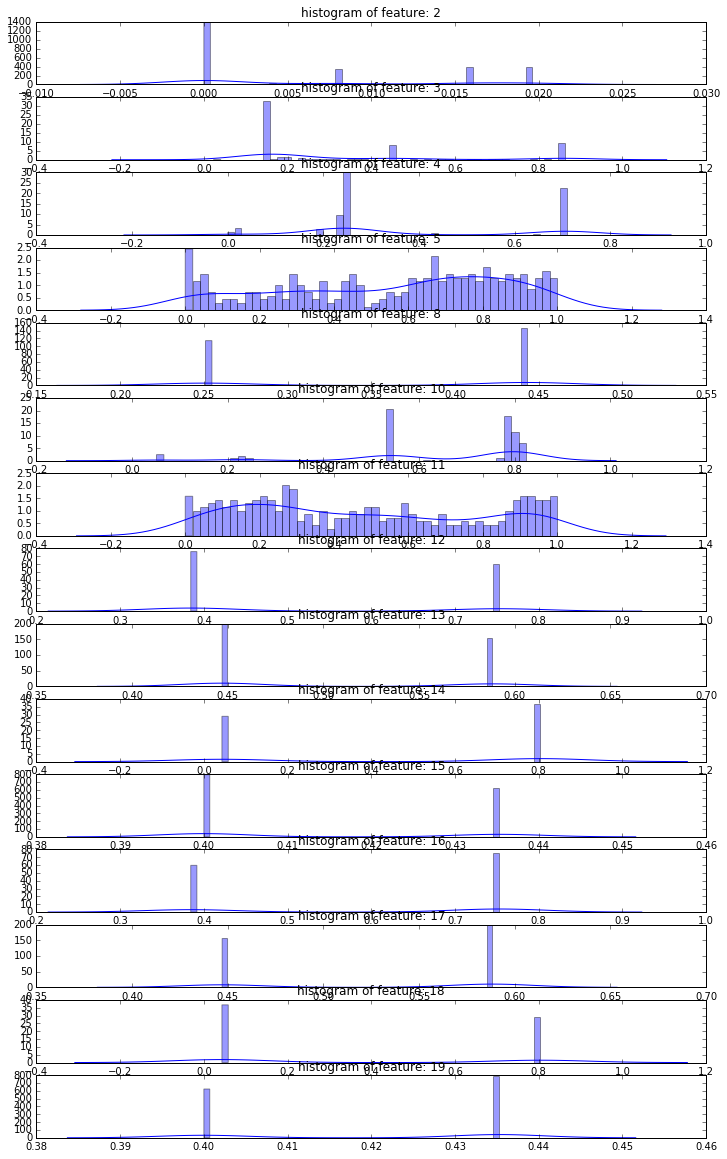

In [573]:
mydf = pd.DataFrame(train_x)
print mydf.shape

# remove static columns
mydf = mydf.loc[:, (mydf != mydf.iloc[0]).any()]

#print mydf
print mydf.shape

plt.figure(figsize=(12,5*4))
gs = gridspec.GridSpec(len(mydf.columns), 1)
for i, cn in enumerate(mydf.columns):
    ax = plt.subplot(gs[i])
    sns.distplot(mydf[cn], bins=50)
    #sns.distplot(mydf[cn][mydf.Class == 0], bins=50)
    ax.set_xlabel('')
    ax.set_title('histogram of feature: ' + str(cn))
plt.show()

# Create and train the neural network
The autoencoder is created and trained below

In [574]:
n_input = train_x.shape[1]
print "n_input = " + str(n_input)
print "n_input_1 = " + str(n_hidden_1)

X = tf.placeholder("float", [None, n_input])

weights = {
    'encoder_h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    #'encoder_h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'decoder_h1': tf.Variable(tf.random_normal([n_hidden_1, n_input])),
    #'decoder_h2': tf.Variable(tf.random_normal([n_hidden_1, n_input])),
}
biases = {
    'encoder_b1': tf.Variable(tf.random_normal([n_hidden_1])),
    #'encoder_b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'decoder_b1': tf.Variable(tf.random_normal([n_input])),
    #'decoder_b2': tf.Variable(tf.random_normal([n_input])),
}

encoder_op = encoder(X)
decoder_op = decoder(encoder_op)

# Prediction
y_pred = decoder_op
# Targets (Labels) are the input data.
y_true = X

# Define batch mse
batch_mse = tf.reduce_mean(tf.pow(y_true - y_pred, 2), 1)

# Define loss and optimizer, minimize the squared error
cost = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(cost)

save_model = os.path.join(data_dir, 'model.ckpt')
saver = tf.train.Saver()

# Initializing the variables
init = tf.global_variables_initializer()

with tf.Session() as sess:
    now = datetime.now()
    sess.run(init)
    total_batch = int(train_x.shape[0]/batch_size)
    print "Total batches = " + str(total_batch)
    
    # Training cycle
    for epoch in range(training_epochs):
        # Loop over all batches
        for i in range(total_batch):
            batch_idx = np.random.choice(train_x.shape[0], batch_size)
            batch_xs = train_x[batch_idx]
            #print batch_xs.shape
            #print train_x.shape
            
            # Run optimization op (backprop) and cost op (to get loss value)
            _, c = sess.run([optimizer, cost], feed_dict={X: batch_xs})

        # Display logs per epoch step
        if epoch % display_step == 0:
            train_batch_mse = sess.run(batch_mse, feed_dict={X: train_x})
            print("Epoch:", '%04d' % (epoch+1),
                  "cost=", "{:.9f}".format(c))

    print("Optimization Finished!")

    save_path = saver.save(sess, save_model)
    print("Model saved in file: %s" % save_path)
    
    print train_batch_mse

n_input = 20
n_input_1 = 15
Total batches = 1
('Epoch:', '0001', 'cost=', '1.027714133')
('Epoch:', '0002', 'cost=', '1.024523497')
('Epoch:', '0003', 'cost=', '1.036035895')
('Epoch:', '0004', 'cost=', '1.019764185')
('Epoch:', '0005', 'cost=', '1.025214076')
('Epoch:', '0006', 'cost=', '1.024981618')
('Epoch:', '0007', 'cost=', '1.012497425')
('Epoch:', '0008', 'cost=', '1.028776646')
('Epoch:', '0009', 'cost=', '1.036417246')
('Epoch:', '0010', 'cost=', '1.035491347')
('Epoch:', '0011', 'cost=', '1.038715959')
('Epoch:', '0012', 'cost=', '1.044141650')
('Epoch:', '0013', 'cost=', '1.033511758')
('Epoch:', '0014', 'cost=', '1.029124498')
('Epoch:', '0015', 'cost=', '1.036000013')
('Epoch:', '0016', 'cost=', '1.023240447')
('Epoch:', '0017', 'cost=', '1.035856962')
('Epoch:', '0018', 'cost=', '1.023677707')
('Epoch:', '0019', 'cost=', '1.030077934')
('Epoch:', '0020', 'cost=', '1.035444379')
('Epoch:', '0021', 'cost=', '1.030627489')
('Epoch:', '0022', 'cost=', '1.017899513')
('Epoch:

('Epoch:', '0305', 'cost=', '0.296838939')
('Epoch:', '0306', 'cost=', '0.295664400')
('Epoch:', '0307', 'cost=', '0.298958570')
('Epoch:', '0308', 'cost=', '0.300224990')
('Epoch:', '0309', 'cost=', '0.306996465')
('Epoch:', '0310', 'cost=', '0.283000231')
('Epoch:', '0311', 'cost=', '0.310860723')
('Epoch:', '0312', 'cost=', '0.291481793')
('Epoch:', '0313', 'cost=', '0.307843834')
('Epoch:', '0314', 'cost=', '0.287524253')
('Epoch:', '0315', 'cost=', '0.295863777')
('Epoch:', '0316', 'cost=', '0.300603807')
('Epoch:', '0317', 'cost=', '0.304085523')
('Epoch:', '0318', 'cost=', '0.289507210')
('Epoch:', '0319', 'cost=', '0.270500124')
('Epoch:', '0320', 'cost=', '0.299001575')
('Epoch:', '0321', 'cost=', '0.292388678')
('Epoch:', '0322', 'cost=', '0.288403571')
('Epoch:', '0323', 'cost=', '0.270458877')
('Epoch:', '0324', 'cost=', '0.284411609')
('Epoch:', '0325', 'cost=', '0.290600032')
('Epoch:', '0326', 'cost=', '0.297863275')
('Epoch:', '0327', 'cost=', '0.259867907')
('Epoch:', 

('Epoch:', '0632', 'cost=', '0.088188127')
('Epoch:', '0633', 'cost=', '0.073601075')
('Epoch:', '0634', 'cost=', '0.082839541')
('Epoch:', '0635', 'cost=', '0.079434156')
('Epoch:', '0636', 'cost=', '0.076768801')
('Epoch:', '0637', 'cost=', '0.077627927')
('Epoch:', '0638', 'cost=', '0.085449308')
('Epoch:', '0639', 'cost=', '0.078410096')
('Epoch:', '0640', 'cost=', '0.082498468')
('Epoch:', '0641', 'cost=', '0.080294326')
('Epoch:', '0642', 'cost=', '0.081533141')
('Epoch:', '0643', 'cost=', '0.072318576')
('Epoch:', '0644', 'cost=', '0.074674100')
('Epoch:', '0645', 'cost=', '0.079993807')
('Epoch:', '0646', 'cost=', '0.087546661')
('Epoch:', '0647', 'cost=', '0.073908433')
('Epoch:', '0648', 'cost=', '0.080404751')
('Epoch:', '0649', 'cost=', '0.080828875')
('Epoch:', '0650', 'cost=', '0.083406970')
('Epoch:', '0651', 'cost=', '0.077075072')
('Epoch:', '0652', 'cost=', '0.078255400')
('Epoch:', '0653', 'cost=', '0.078330137')
('Epoch:', '0654', 'cost=', '0.073287569')
('Epoch:', 

('Epoch:', '0975', 'cost=', '0.022394214')
('Epoch:', '0976', 'cost=', '0.021657424')
('Epoch:', '0977', 'cost=', '0.021365581')
('Epoch:', '0978', 'cost=', '0.021905376')
('Epoch:', '0979', 'cost=', '0.021924539')
('Epoch:', '0980', 'cost=', '0.022218121')
('Epoch:', '0981', 'cost=', '0.022064256')
('Epoch:', '0982', 'cost=', '0.021709275')
('Epoch:', '0983', 'cost=', '0.021389874')
('Epoch:', '0984', 'cost=', '0.022863155')
('Epoch:', '0985', 'cost=', '0.022494217')
('Epoch:', '0986', 'cost=', '0.022305511')
('Epoch:', '0987', 'cost=', '0.022994930')
('Epoch:', '0988', 'cost=', '0.021097023')
('Epoch:', '0989', 'cost=', '0.021760421')
('Epoch:', '0990', 'cost=', '0.021228736')
('Epoch:', '0991', 'cost=', '0.021156009')
('Epoch:', '0992', 'cost=', '0.022114003')
('Epoch:', '0993', 'cost=', '0.021140510')
('Epoch:', '0994', 'cost=', '0.022156063')
('Epoch:', '0995', 'cost=', '0.020402931')
('Epoch:', '0996', 'cost=', '0.021673180')
('Epoch:', '0997', 'cost=', '0.021715792')
('Epoch:', 

# Test the network
Use the same input for testing. Get the mean square error and also the output data (reconstructed_x)

In [575]:
save_model = os.path.join(data_dir, 'model.ckpt')
saver = tf.train.Saver()

# Initializing the variables
init = tf.global_variables_initializer()

with tf.Session() as sess:
    now = datetime.now()
    
    saver.restore(sess, save_model)
    
    test_batch_mse, reconstructed_x = sess.run([batch_mse, decoder_op], feed_dict={X: train_x})
    
    print("Epoch:", '%04d' % (epoch+1),
                  "cost=", "{:.9f}".format(c))
    
    print reconstructed_x
    print test_batch_mse

INFO:tensorflow:Restoring parameters from ./model.ckpt
('Epoch:', '1000', 'cost=', '0.021004546')
[[ 0.30762935 -0.02462667  0.01183657 ...,  0.5132618   0.19342549
   0.4641898 ]
 [ 0.2314589   0.07754357  0.0101471  ...,  0.554748    0.55376118
   0.22059189]
 [ 0.22816464 -0.09610318 -0.01590416 ...,  0.56282204  0.19667983
   0.46285951]
 ..., 
 [ 0.29119691 -0.13583671 -0.08671917 ...,  0.56252444  0.11795112
   0.42350051]
 [ 0.30964079 -0.0463826  -0.03249847 ...,  0.53858626  0.16934381
   0.39766672]
 [ 0.28577483  0.07140185  0.11504132 ...,  0.48216107  0.24518168
   0.47393525]]
[ 0.00770061  0.03931884  0.02548652  0.03769279  0.01100872  0.01826436
  0.01827044  0.01602255  0.02046964  0.01740212  0.06375223  0.02282324
  0.02508634  0.01572864  0.00991941  0.01840725  0.025569    0.00759198
  0.02092843  0.01781954  0.025661    0.00758651  0.03900937  0.0074204
  0.02461334  0.01165138  0.03648229  0.0154328   0.03492671  0.01729018
  0.02051199  0.0155338   0.00880796  

# Show the Error Distribution
Display the Mean Square Error distribution

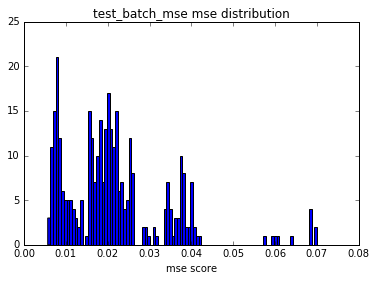

In [576]:
plt.hist(test_batch_mse, bins = 100)
plt.title("test_batch_mse mse distribution")
plt.xlabel("mse score")
plt.show()

# Display also the input/output data histograms
To see how the neural autoencoder has learned on the features. Compare input and output.

(348, 20)
(348, 20)
(348, 20)
(348, 15)


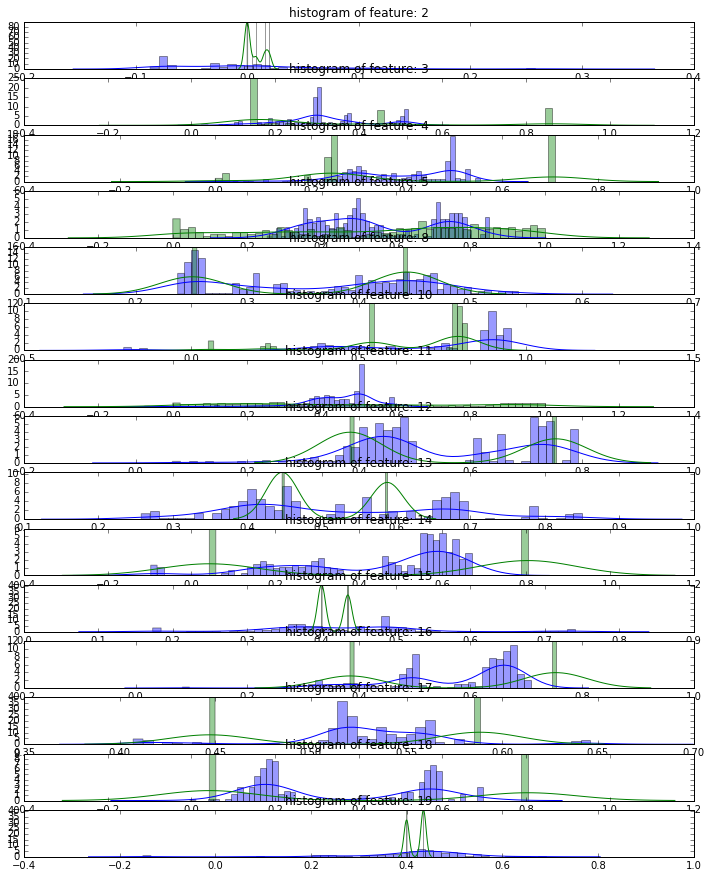

In [577]:
mydf = pd.DataFrame(reconstructed_x)
mydf_orig = pd.DataFrame(train_x)
print mydf.shape
print mydf_orig.shape

# remove static columns
mydf = mydf.loc[:, (mydf != mydf.iloc[0]).any()]
mydf_orig = mydf_orig.loc[:, (mydf_orig != mydf_orig.iloc[0]).any()]

print mydf.shape
print mydf_orig.shape

plt.figure(figsize=(12,5*4))
gs = gridspec.GridSpec(len(mydf.columns), 1)
for i, cn in enumerate(mydf_orig.columns):
    ax = plt.subplot(gs[i])
    sns.distplot(mydf[cn], bins=50)
    sns.distplot(mydf_orig[cn], bins=50)
    #sns.distplot(mydf[cn][mydf.Class == 0], bins=50)
    ax.set_xlabel('')
    ax.set_title('histogram of feature: ' + str(cn))
plt.show()

# Generate output anomaly pcap
The top N packets with highest MSE are included in the output pcap. ad_test.pcap is created in the current directory.

In [578]:
# Generate pcap
# open TMP file used by text2pcap
infile = 'ad_test'
file = infile + '.tmp'
f = open(file, 'w')


print type(test_batch_mse)

# get top N of mse
N = 30
top_N = test_batch_mse.argsort()[-N:][::-1]
print top_N

for j in top_N:
    #print mse
    print("MSE = " + str(test_batch_mse[j]))
    print(str(df.iloc[[j]]))
    # pcap
    df_to_pcap(j, df, file)

    
# pcap
f.close()
to_pcap_file(infile + '.tmp', infile + '.pcap')
os.remove(infile + '.tmp')
print("Generated " + infile + ".pcap")

<type 'numpy.ndarray'>
[309  40 292 344 218 257  10 316  69 236 295 123  51  52 107  70 166 255
 153 181 310  65 333   1  22 239 278  57  42 343]
MSE = 0.0700179
                                             frame_raw linux_cooked_header  \
309  0008e23b5601003048624e4a0800450000280000400040...               False   

                                       ip_raw  label  
309  450000280000400040063ef2c0960b6f6272cd66    0.0  
MSE = 0.0700179
                                            frame_raw linux_cooked_header  \
40  0008e23b5601003048624e4a0800450000280000400040...               False   

                                      ip_raw  label  
40  450000280000400040063ef2c0960b6f6272cd66    0.0  
MSE = 0.0685012
                                             frame_raw linux_cooked_header  \
292  0008e23b5601003048624e4a0800450000300000400040...               False   

                                       ip_raw  label  
292  450000300000400040063eeac0960b6f6272cd66    0.0  
MSE = 0.0

Generated ad_test.pcap


# Acknowledgment
The above code was built by using the following work. And thanks to these authors.
* https://github.com/aaxwaz/Fraud-detection-using-deep-learning
* https://github.com/curiousily/Credit-Card-Fraud-Detection-using-Autoencoders-in-Keras